# Segementation Comparision



## Get Data and Labels

In [7]:
import os
import itertools

In [8]:
data_dir = '../verification_data/segmentation_data/test'
# get all the filenames
filenames = os.listdir(data_dir)
# keep only tif files
filenames = [f for f in filenames if f.endswith('.nrrd')]
# separate into images and labels
images = [os.path.join(data_dir, f) for f in filenames if 'segmentation' not in f]
labels = [os.path.join(data_dir, f) for f in filenames if 'segmentation' in f]
# create a matching list of pairs of images and labels
image_to_label = {}
label_to_image = {}
for image, label in itertools.product(images, labels):
    if os.path.splitext(image)[0] == os.path.splitext(label)[0].replace('_segmentation', ''):
        image_to_label[image] = label
        label_to_image[label] = image
# keep only the images that have a label
images = list(image_to_label.keys())
labels = list(image_to_label.values())

In [9]:
# Get the templates
template_dir = '../verification_data/templates'
template_filenames = os.listdir(template_dir)
# keep only nrrd files
template_filenames = [f for f in template_filenames if f.endswith('.nrrd')]
print(template_filenames)

['obiroi_template_20231127_1647_0.4x0.4x0.4.nrrd', 'obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd', 'obiroi_template_20231127_1722_0.2x0.2x0.2.nrrd']


In [10]:
# target resolution
target_resolution = "0.8x0.8x0.8" # in microns
# get the template with the correct resolution in the name 
template_filename = [f for f in template_filenames if target_resolution in f]
assert len(template_filename) == 1, "There should be only one template with the target resolution"
template_filename = template_filename[0]
# template path
template_path = os.path.join(template_dir, template_filename)

In [11]:
processed_data_dir = 'processed_data'

In [12]:
# loop over the images and labels and check if names have LEFT or RIGHT in them
# if LEFT, mirror the image and label
# if RIGHT, do nothing
new_images = []
new_labels = []

commands_to_run = []

for image in images:
    current_command = []
    if 'LEFT' in image:
        # mirror the image
        print("Mirroring image: " + image)
        # create a mirrored image at the processed data directory
        mirrored_image = os.path.join(processed_data_dir, os.path.basename(image).replace('LEFT', 'RIGHT'))
        # check if the image already exists
        if os.path.isfile(mirrored_image):
            print("The mirrored image already exists. Skipping.")
            new_images.append(mirrored_image)
            continue
        reflection_matrix = os.path.join(processed_data_dir, os.path.basename(image)[:-5] + "_reflection_matrix.mat")
        # create the command
        flip_brain_command1 = "ImageMath 3 {} ReflectionMatrix {} 0".format(reflection_matrix, image)
        flip_brain_command2 = "antsApplyTransforms -d 3 -i {} -o {} -t {} -r {}".format(image, mirrored_image, reflection_matrix, image)
        # run the commands
        print(flip_brain_command1)
        # os.system(flip_brain_command1)
        current_command.append(flip_brain_command1)
        print(flip_brain_command2)
        # os.system(flip_brain_command2)
        current_command.append(flip_brain_command2)
        # change the image name to the mirrored image
        new_images.append(mirrored_image)
    else:
        # copy the image to the processed data directory
        print("Copying image: " + image)
        new_image = os.path.join(processed_data_dir, os.path.basename(image))
        # check if the image already exists
        if os.path.isfile(new_image):
            print("The image already exists. Skipping.")
            new_images.append(new_image)
            continue
        # shutil.copyfile(image, new_image)
        current_command.append("cp {} {}".format(image, new_image))
        # change the image name to the copied image
        new_images.append(new_image)
    commands_to_run.append(current_command)

for label in labels:
    current_command = []
    if 'LEFT' in label:
        # mirror the label
        print("Mirroring label: " + label)
        # create a mirrored label at the processed data directory
        mirrored_label = os.path.join(processed_data_dir, os.path.basename(label).replace('LEFT', 'RIGHT'))
        # check if the label already exists
        if os.path.isfile(mirrored_label):
            print("The mirrored label already exists. Skipping.")
            new_labels.append(mirrored_label)
            continue
        reflection_matrix = os.path.join(processed_data_dir, os.path.basename(label)[:-5] + "_reflection_matrix.mat")
        # create the command
        flip_brain_command1 = "ImageMath 3 {} ReflectionMatrix {} 0".format(reflection_matrix, label)
        flip_brain_command2 = "antsApplyTransforms -d 3 -i {} -o {} -t {} -r {}".format(label, mirrored_label, reflection_matrix, label)
        # run the commands
        print(flip_brain_command1)
        # os.system(flip_brain_command1)
        current_command.append(flip_brain_command1)
        print(flip_brain_command2)
        # os.system(flip_brain_command2)
        current_command.append(flip_brain_command2)
        # change the label name to the mirrored label
        new_labels.append(mirrored_label)
    else:
        # copy the label to the processed data directory
        print("Copying label: " + label)
        new_label = os.path.join(processed_data_dir, os.path.basename(label))
        # check if the label already exists
        if os.path.isfile(new_label):
            print("The label already exists. Skipping.")
            new_labels.append(new_label)
            continue
        # shutil.copyfile(label, new_label)
        current_command.append("cp {} {}".format(label, new_label))
        # change the label name to the copied label
        new_labels.append(new_label)
    commands_to_run.append(current_command)

def run_commands(commands_to_run):
    for command in commands_to_run:
        # print(command)
        os.system(command)

# get CPU count using os
n_cpu = os.cpu_count()

# run the commands in parallel
from joblib import Parallel, delayed
_ = Parallel(n_jobs=n_cpu)(delayed(run_commands)(commands) for commands in commands_to_run)

Mirroring image: ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed.nrrd
ImageMath 3 processed_data/220214_brain3_LEFT_processed_reflection_matrix.mat ReflectionMatrix ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed.nrrd 0
antsApplyTransforms -d 3 -i ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed.nrrd -o processed_data/220214_brain3_RIGHT_processed.nrrd -t processed_data/220214_brain3_LEFT_processed_reflection_matrix.mat -r ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed.nrrd
Copying image: ../verification_data/segmentation_data/test/LLA4_SYM_processed.nrrd
Mirroring label: ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed_segmentation.nrrd
ImageMath 3 processed_data/220214_brain3_LEFT_processed_segmentation_reflection_matrix.mat ReflectionMatrix ../verification_data/segmentation_data/test/220214_brain3_LEFT_processed_segmentation.nrrd 0
antsApplyTransforms -d 3 -i .

In [13]:
# resample all of the images
if os.path.isdir("{}/backup".format(processed_data_dir)):
    command = "rm -rf {}/backup".format(processed_data_dir)
    !{command}
# create the backup subdirectory
command = "mkdir -p {}/backup".format(processed_data_dir)
!{command}
command = 'mv {}/*.nrrd {}/backup'.format(processed_data_dir, processed_data_dir)
!{command}
command = 'mv {}/*.mat {}/backup'.format(processed_data_dir, processed_data_dir)
!{command}

In [14]:
n_jobs = os.listdir(processed_data_dir+'/backup')
# filter only nrrd files
n_jobs = [f for f in n_jobs if f.endswith('.nrrd')]
n_jobs = len(n_jobs)
print("Number of jobs: {}".format(n_jobs))

Number of jobs: 4


In [15]:
command = f'poetry run python ../../scripts/resample.py -i {processed_data_dir+"/backup"} -o {processed_data_dir} -v {target_resolution} -n {min(n_jobs, n_cpu)}'
!{command}

Kronauer Lab - Microscopy Image Processing Pipeline
Confocal Resampler by Rishika Mohanta
Version 1.1.0

Resampling file 1 of 4
Target resolution: 0.8 μm x 0.8 μm x 0.8 μm
Log file: processed_data/LLA4_SYM_processed_segmentation_resampled_0.8x0.8x0.8_out.log
Error file: processed_data/LLA4_SYM_processed_segmentation_resampled_0.8x0.8x0.8_err.log
Resampling file 2 of 4
Target resolution: 0.8 μm x 0.8 μm x 0.8 μm
Log file: processed_data/220214_brain3_RIGHT_processed_segmentation_resampled_0.8x0.8x0.8_out.log
Error file: processed_data/220214_brain3_RIGHT_processed_segmentation_resampled_0.8x0.8x0.8_err.log
Resampling file 3 of 4
Target resolution: 0.8 μm x 0.8 μm x 0.8 μm
Log file: processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8_out.log
Error file: processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8_err.log
Resampling file 4 of 4
Target resolution: 0.8 μm x 0.8 μm x 0.8 μm
Log file: processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8_out.log
Error f

In [16]:
# add resampled_<target_resolution> to the filenames
new_images = [x.replace('.nrrd', '_resampled_{}.nrrd'.format(target_resolution)) for x in new_images]
new_labels = [x.replace('.nrrd', '_resampled_{}.nrrd'.format(target_resolution)) for x in new_labels]

In [17]:
images = new_images
labels = new_labels
# recreate a matching list of pairs of images and labels
image_to_label = {}
label_to_image = {}
for image, label in itertools.product(images, labels):
    if os.path.splitext(image)[0] == os.path.splitext(label)[0].replace('_segmentation', ''):
        image_to_label[image] = label
        label_to_image[label] = image
# keep only the images that have a label
images = list(image_to_label.keys())
labels = list(image_to_label.values())

In [18]:
images

['processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8.nrrd',
 'processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8.nrrd']

In [19]:
# loop over the images and register them to the template using ANTs

# loop over the images
for image in images:
    # generate output prefix
    output_prefix = os.path.basename(image).replace('.nrrd', '_')
    output_prefix = os.path.join(processed_data_dir, output_prefix)
    # check if files with this prefix already exist
    if os.path.isfile(output_prefix + 'Warped.nii.gz'):
        print("The registered image already exists. Skipping.")
        continue
    # create registration command
    command = f'antsRegistrationSyN.sh -d 3 -f {template_path} -m {image}'
    command += f' -o {output_prefix} -n {n_cpu} -t s -y 1 >{output_prefix}.log 2>{output_prefix}.err'
    # run the command using os.system
    print(command)
    os.system(command)

antsRegistrationSyN.sh -d 3 -f ../verification_data/templates/obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd -m processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8.nrrd -o processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8_ -n 112 -t s -y 1 >processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8_.log 2>processed_data/220214_brain3_RIGHT_processed_resampled_0.8x0.8x0.8_.err
antsRegistrationSyN.sh -d 3 -f ../verification_data/templates/obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd -m processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8.nrrd -o processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8_ -n 112 -t s -y 1 >processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8_.log 2>processed_data/LLA4_SYM_processed_resampled_0.8x0.8x0.8_.err


In [ ]:
# loop over the labels and warp them to the template using the generated transforms during registration
# loop over the labels
for label in labels:
    # generate output prefix
    output_prefix = os.path.basename(label).replace('.nrrd', '_')
    output_prefix = processed_data_dir + '/warped_' + output_prefix
    # get the corresponding image
    image = label_to_image[label]
    # get the corresponding output prefix
    image_output_prefix = os.path.basename(image).replace('.nrrd', '_')
    image_output_prefix = processed_data_dir + '/' + image_output_prefix
    # create registration command
    command = f'antsApplyTransforms -d 3 -i {label} -r {template_path}'
    command += f' -o {output_prefix}.nrrd -n GenericLabel -t {image_output_prefix}1Warp.nii.gz'
    command += f' -t {image_output_prefix}0GenericAffine.mat >{output_prefix}.log 2>{output_prefix}.err'
    # run the command using os.system
    print(command)
    os.system(command)

antsApplyTransforms -d 3 -i processed_data/201213_2-6_brain3_RIGHT_processed_segmentation.nrrd -r ../verification_data/templates/obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd -o processed_data/warped_201213_2-6_brain3_RIGHT_processed_segmentation_.nrrd -n GenericLabel -t processed_data/201213_2-6_brain3_RIGHT_processed_1Warp.nii.gz -t processed_data/201213_2-6_brain3_RIGHT_processed_0GenericAffine.mat >processed_data/warped_201213_2-6_brain3_RIGHT_processed_segmentation_.log 2>processed_data/warped_201213_2-6_brain3_RIGHT_processed_segmentation_.err
antsApplyTransforms -d 3 -i processed_data/201213_2-1_brain1_RIGHT_processed_segmentation.nrrd -r ../verification_data/templates/obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd -o processed_data/warped_201213_2-1_brain1_RIGHT_processed_segmentation_.nrrd -n GenericLabel -t processed_data/201213_2-1_brain1_RIGHT_processed_1Warp.nii.gz -t processed_data/201213_2-1_brain1_RIGHT_processed_0GenericAffine.mat >processed_data/warped_201213_2-1_bra

antsApplyTransforms -d 3 -i processed_data/220216_brain10_RIGHT_processed_segmentation.nrrd -r ../verification_data/templates/obiroi_template_20231127_1647_0.8x0.8x0.8.nrrd -o processed_data/warped_220216_brain10_RIGHT_processed_segmentation_.nrrd -n GenericLabel -t processed_data/220216_brain10_RIGHT_processed_1Warp.nii.gz -t processed_data/220216_brain10_RIGHT_processed_0GenericAffine.mat >processed_data/warped_220216_brain10_RIGHT_processed_segmentation_.log 2>processed_data/warped_220216_brain10_RIGHT_processed_segmentation_.err


In [ ]:
# open the warped labels using pynrrd and save them as numpy arrays
import nrrd
import numpy as np

final_labels = []
final_labels_paths = []

# loop over the labels
for label in labels:
    # generate output prefix
    output_prefix = os.path.basename(label).replace('.nrrd', '_')
    output_prefix = processed_data_dir + '/warped_' + output_prefix

    # open the label using pynrrd
    label_data, label_header = nrrd.read(output_prefix + '.nrrd')
    # save the label as a numpy array
    np.save(output_prefix + '.npy', label_data)

    final_labels.append(label_data)
    final_labels_paths.append(output_prefix + '.npy')

In [ ]:
final_labels[0].shape

(500, 498, 268)

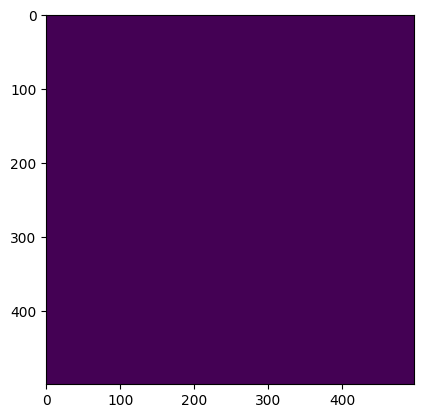

In [18]:
import matplotlib.pyplot as plt
plt.imshow(final_labels[0][:, :, 100])